In [5]:
# Import required tools/tasks
from casatools import simulator, image, table, coordsys, measures, componentlist, quanta, ctsys, vpmanager
from casatasks import tclean, ft, imhead, listobs, exportfits, flagdata, bandpass, applycal
from casatasks.private import simutil

import os
import pylab as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


# Instantiate all the required tools
sm = simulator()
ia = image()
tb = table()
cs = coordsys()
me = measures()
qa = quanta()
cl = componentlist()
vp = vpmanager()
qa = quanta()
mysu = simutil.simutil()

measures data is not available



data_update: path must exist as a directory and it must be owned by the user, path = /u/fcitterio/.casa/data


The expected casa data was not found at measurespath. CASA may still work if the data can be found in datapath.
The expected measures data was not found at measurespath. CASA may still work if the data can be found in datapath.
visit https://casadocs.readthedocs.io/en/stable/notebooks/external-data.html for more information

2025-06-17 15:16:58	SEVERE	::casa	
2025-06-17 15:16:58	SEVERE	::casa	data_update: path must exist as a directory and it must be owned by the user, path = /u/fcitterio/.casa/data
2025-06-17 15:16:58	SEVERE	::casa	
2025-06-17 15:16:58	SEVERE	::casa	Warning: measurespath must exist as a directory and it must be owned by the user.
2025-06-17 15:16:58	SEVERE	::casa	Warning: no auto update is possible on this measurespath by this user.
2025-06-17 15:16:58	SEVERE	::casa	
2025-06-17 15:16:58	SEVERE	::casa	The expected casa data was not found at measurespath. CASA

AutoUpdatesNotAllowed: data_update: path must exist as a directory and it must be owned by the user, path = /u/fcitterio/.casa/data

In [ ]:
def makeMSFrame(msname= "sim_data.ms"):
    """
    Construct an empty measurment set that has the desired observation setup.
    """


    os.system("rm -rf " + msname)
    sm.open(ms=msname);

    # Read/create an antenna configuration  alma.cycle12.10.cfg 
    #antennalist = os.path.join( ctsys.resolve("alma/simmos") ,"vla.d.cfg")   
    antennalist = os.path.join( ctsys.resolve("alma/simmos") ,"alma.cycle9.9.cfg")   


    # Read xyz locations, antenna diameter and name, and telescope name/positoin.
    (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)
    obsposname=telname


    # Now we use the premade antenna configuration to set the simulator
    sm.setconfig(telescopename=telname,
                 x=x,
                 y=y,
                 z=z,
                 dishdiameter=d,
                 mount='alt-az',
                 antname=an,
                 coordsystem='global',
                 referencelocation=me.observatory(obsposname))
    
    # Set the polarization mode(this goes to the FEED subtable)
    sm.setfeed(mode='perfect R L', pol=['']);
    
    ## Set the spectral window and polarization 
    #Call multiple times with different names for multiple SPWs
    sm.setspwindow(spwname="LBand",
                   freq='100.0GHz',
                   deltafreq='0.01GHz',
                   freqresolution='0.02GHz',
                   nchannels=10,
                   stokes='RR LL')
    
    #set source position and name, repeat for multiple sources
    sm.setfield( sourcename="fake",
                sourcedirection=me.direction(rf='J2000', v0='19h59m28.5s', v1='40d44m01.5s'))
    
    ## Set shadow/elevation limits. These will set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='1deg')

    # Leave autocorrelations out of ms, the correlation of an antenna with itself
    sm.setauto(autocorrwt=0.0)

    # Set integration time and the convention to use for timerange specificaition
    sm.settimes(integrationtime='1000s',
                usehourangle=True,
                referencetime=me.epoch('UTC','2019/10/4/00:00:00'))
    #Make the MS metadata and UVW values for one scan and ddid
    ## Call multiple times for multiple scans
    ## call this with different sourcenames(fields) and spw/pol settings as defined above.
    ## Timesteps will be defined in intervals of integration time. betweeen starttime and stoptime
    sm.observe(sourcename="fake",
               spwname="LBand",
               starttime='-1h',
               stoptime='+1h')
    
    sm.close()

    #unflag everything, unless you care about elevation and shadow flags
    flagdata(vis=msname, mode='unflag')
    

def plotData(msname='sim_data.ms', myplot='uv'):
    """
    Options : myplot='uv'
              myplot='data_spectrum'
    """
    from matplotlib.collections import LineCollection
    tb.open(msname)

    # UV coverage plot
    if myplot=='uv':
        pl.figure(figsize=(4,4))
        pl.clf()
        uvw = tb.getcol('UVW')
        pl.plot( uvw[0], uvw[1], '.')
        pl.plot( -uvw[0], -uvw[1], '.')
        pl.title('UV Coverage')
    
    # Spectrum of chosen column. Make a linecollection out of each row in the MS.
    if myplot=='data_spectrum' or myplot=='corr_spectrum' or myplot=='resdata_spectrum'  or myplot=='rescorr_spectrum' or myplot=='model_spectrum':
        dats=None
        if myplot=='data_spectrum':
            dats = tb.getcol('DATA')
        if myplot=='corr_spectrum':
            dats = tb.getcol('CORRECTED_DATA')
        if myplot=='resdata_spectrum':
            dats = tb.getcol('DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='rescorr_spectrum':
            dats = tb.getcol('CORRECTED_DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='model_spectrum':
            dats = tb.getcol('MODEL_DATA')
            
        xs = np.zeros((dats.shape[2],dats.shape[1]),'int')
        for chan in range(0,dats.shape[1]):
            xs[:,chan] = chan
    
        npl = dats.shape[0]
        fig, ax = pl.subplots(1,npl,figsize=(10,4))
        
        for pol in range(0,dats.shape[0]):
            x = xs
            y = np.abs(dats[pol,:,:]).T
            data = np.stack(( x,y ), axis=2)
            ax[pol].add_collection(LineCollection(data))
            ax[pol].set_title(myplot + ' \n pol '+str(pol))
            ax[pol].set_xlim(x.min(), x.max())
            ax[pol].set_ylim(y.min(), y.max())
        pl.show()
    
    tb.close()

In [3]:
makeMSFrame()


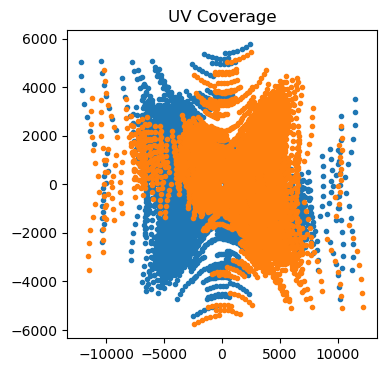

In [4]:
plotData(myplot='uv')

In [5]:
listobs(vis='sim_data.ms', listfile='obslist.txt', verbose=False, overwrite=True)
## print(os.popen('obslist.txt').read()) # ?permission denied?
fp = open('obslist.txt')
for aline in fp.readlines():
    print(aline.replace('\n',''))
fp.close()

           MeasurementSet Name:  /home/francesco/Desktop/master_thesis/master_thesis_code/notebooks/sim_data.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: ALMA(43 antennas)
Data records: 6321       Total elapsed time = 7000 seconds
   Observed from   03-Oct-2019/22:42:12.7   to   04-Oct-2019/00:38:52.7 (UTC)

Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake                19:59:28.500000 +40.44.01.50000 J2000   0           6321
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      LBand     10   TOPO  100000.000     10000.000    100000.0 100045.0000   RR  LL
Antennas: 43 'name'='station' 
   ID=   0-4: 'A074'='P', 'A094'='P', 'A101'='P', 'A104'='P', 'A105'='P', 
   ID=   5-9: 'A108'='P', 'A110'='P', 'A111'='P', 'A115'='P', 'A116'='P', 
   ID= 10-14: '

In [6]:
os.system('rm -rf fake*')
tclean(vis='sim_data.ms',
       imagename='fake',
       field='0',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[250,250],
       cell=['0.01arcsec'],
       weighting='natural',
       threshold='0.0mJy',
       interactive=True)

2025-03-25 09:25:32	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2298)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 0,
 'cyclethreshold': 0,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0,
 'iterdone': 0,
 'loopgain': 0,
 'maxpsffraction': 0,
 'maxpsfsidelobe': 0,
 'minpsffraction': 0,
 'niter': 0,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 3,
 'summarymajor': array([0]),
 'summaryminor': {0: {0: {0: {'iterDone': [0.0],
     'peakRes': [0.0],
     'modelFlux': [0],
     'cycleThresh': [0.0]}}}},
 'threshold': '0.0mJy',
 'stopDescription': 'Zero iterations performed'}

In [42]:
# Display an image using AstroPy, with coordinate system rendering.
def dispAstropy(imname='sim_onepoint_true.im'):
        exportfits(imagename=imname, fitsimage=imname+'.fits', overwrite=True)
        hdu = fits.open(imname+'.fits')[0]
        wcs = WCS(hdu.header,naxis=2)
        fig = pl.figure()
        fig.add_subplot(121, projection=wcs)
        pl.imshow(hdu.data[0,0,:,:], origin='lower', cmap=pl.cm.viridis)
        pl.xlabel('RA')
        pl.ylabel('Dec')

def dispImage(imname='sim_onepoint_true.im', useAstropy=False):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    pl.figure(figsize=(10,4))
    pl.clf()
    if shp[3]>1:
        pl.subplot(121)
    if useAstropy==False:
        pl.imshow(pix[:,:,0,0])
        pl.title('Image from channel 0')
    else:
        dispAstropy(imname)
    if shp[3]>1:
        pl.subplot(122)
        ploc = np.where( pix == pix.max() )
        pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
        pl.title('Spectrum at source peak')
        pl.xlabel('Channel')
        

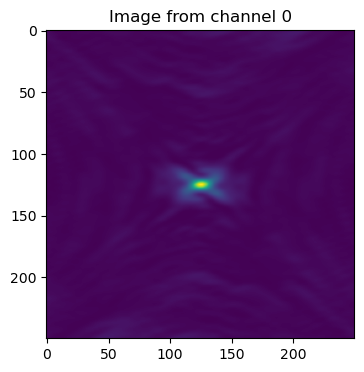

In [8]:
dispImage(imname='fake.psf', useAstropy=False)

# Todo

The size of the cell should be choosen in a smart way. Either by the approximation form the longest baseline, or trough more
precise evaluation of the main lobe of the psf.

the size of the field should be choosen.

Convert the psf to a torch tensor

The images need to be generated to match the psf size. 

The problem of choosing a smaller cell size, in order to standardize the image sizes for training, is a higher computation time.
Could this be an acceptable thing?

Otherwise, we could maybe modify the images at the beginning of the CNN, to match their sizes

### Choosing the cell based on the longest baseline

We set the cell size to 0.1 arcseconds, which places ~5 pixels across the synthesized beam. As a rule of thumb, we'd like ~5 pixels across the smallest direction of our elliptical beam. For a small dataset, you may be able to determine a good cell size with a quick imaging call, and note the beam calculated by tclean. For many ALMA projects, however, this could take a substantial amount of time! You can estimate what the cell size should be by looking again at the uv-coverage. Change the x-axis to uvwave, and the cell size is roughly 206265/(longest baseline in wavelengths)/(number of cells across the beam). For this MS, this works out to 0.09", which we round up to 0.1". As you will see, tclean reports a synthesized beam size of 0.51" x 0.42", making this a decent choice.

(3, 6321)


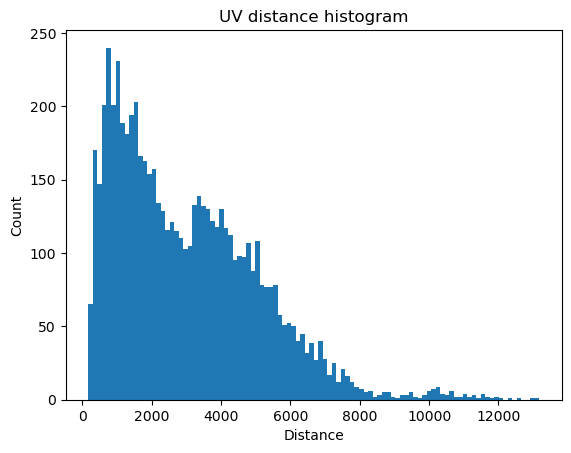

Max radius: 13178.905994082876
This, when compred to the uvwave plot of casa, seems to be not in units of wavelength.
Max radius in wavelengths: 4392968.664694292
Confirmation from the docs, UVW is in meters.
this seems to match the uvwave plot in casa, which is in units of wavelengths.


In [9]:
tb.open('sim_data.ms')
uvw = tb.getcol('UVW')
tb.close()
print(uvw.shape)

uvdist= np.sqrt(uvw[0]**2 + uvw[1]**2)
pl.figure()
pl.hist(uvdist, bins=100)
pl.title('UV distance histogram')
pl.xlabel('Distance')
pl.ylabel('Count')
pl.show()

max_uvdist_radius = uvdist.max()
print('Max radius:', max_uvdist_radius)
print('This, when compred to the uvwave plot of casa, seems to be not in units of wavelength.')
#100 gigahertz in meters are 0.003 meters.
print('Max radius in wavelengths:', max_uvdist_radius/0.003)
print('Confirmation from the docs, UVW is in meters.')
print("this seems to match the uvwave plot in casa, which is in units of wavelengths.")


### How to deal with multiple spectral channels? 

I guess we could loop over each spectral channel and divide the uvdist by the central wavelength.
Somehow casa plotms does this authomatically.... 


In [10]:
#206265/(longest baseline in wavelengths)/(number of cells across the beam).

number_of_cells_across_beam=8
cell_size_arcsec=206265/(max_uvdist_radius/0.003)/number_of_cells_across_beam

In [11]:
cell_size_arcsec_str = str(cell_size_arcsec)+'arcsec'
os.system('rm -rf fake*')
tclean(vis='sim_data.ms',
       imagename='fake',
       field='0',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[250,250],
       cell=[cell_size_arcsec_str],
       weighting='natural',
       threshold='0.0mJy',
       interactive=True)

2025-03-25 09:25:33	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2298)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 0,
 'cyclethreshold': 0,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0,
 'iterdone': 0,
 'loopgain': 0,
 'maxpsffraction': 0,
 'maxpsfsidelobe': 0,
 'minpsffraction': 0,
 'niter': 0,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 3,
 'summarymajor': array([0]),
 'summaryminor': {0: {0: {0: {'iterDone': [0.0],
     'peakRes': [0.0],
     'modelFlux': [0],
     'cycleThresh': [0.0]}}}},
 'threshold': '0.0mJy',
 'stopDescription': 'Zero iterations performed'}

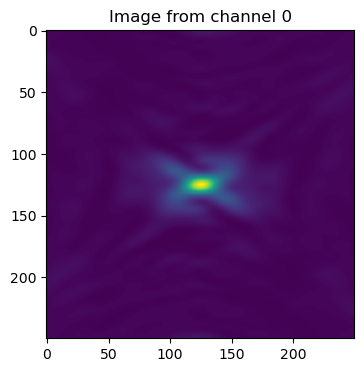

In [ ]:
dispImage(imname='fake.psf', useAstropy=False)

### Setting the field size to be always 8 arcsec



In [13]:
img_size = round(4.0/cell_size_arcsec)
os.system('rm -rf fake*')
tclean(vis='sim_data.ms',
       imagename='fake',
       field='0',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[img_size,img_size],
       cell=[cell_size_arcsec_str],
       weighting='natural',
       threshold='0.0mJy',
       interactive=True)

2025-03-25 09:25:33	WARN	SynthesisParamsImage::buildCoordinateSystem (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2565)	imsize with 682 pixels is not an efficient imagesize. Try 720 instead.
2025-03-25 09:25:34	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2298)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 0,
 'cyclethreshold': 0,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0,
 'iterdone': 0,
 'loopgain': 0,
 'maxpsffraction': 0,
 'maxpsfsidelobe': 0,
 'minpsffraction': 0,
 'niter': 0,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 3,
 'summarymajor': array([0]),
 'summaryminor': {0: {0: {0: {'iterDone': [0.0],
     'peakRes': [0.0],
     'modelFlux': [0],
     'cycleThresh': [0.0]}}}},
 'threshold': '0.0mJy',
 'stopDescription': 'Zero iterations performed'}

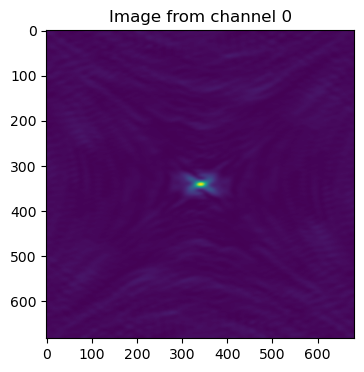

In [14]:
dispImage(imname='fake.psf', useAstropy=False)


### Convert the psf to a tensor

torch.Size([682, 682])


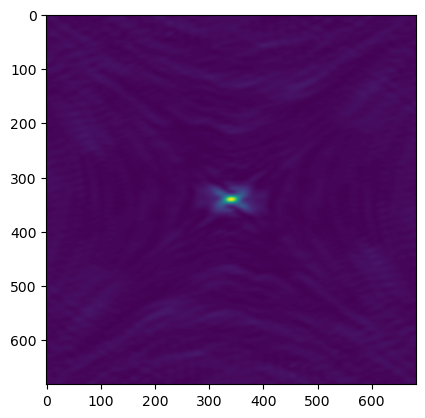

In [15]:
import torch
import matplotlib.pyplot as plt

ia.open('fake.psf')
pix=ia.getchunk()
ia.close()
image= pix[:, :,0, 0]
tensor=torch.tensor(image)
plt.imshow(tensor)

print(tensor.shape)

#save the psf tensor in the folder psfs
torch.save(tensor, '../psfs/psf_1.pt')

### The psf size should be actually double the size of the image 

Now lets test how much time does it take to convolve this beast with a fake random image 

torch.Size([1, 1, 341, 341])


/tmp/ipykernel_373287/125372314.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('../psfs/psf_1.pt')


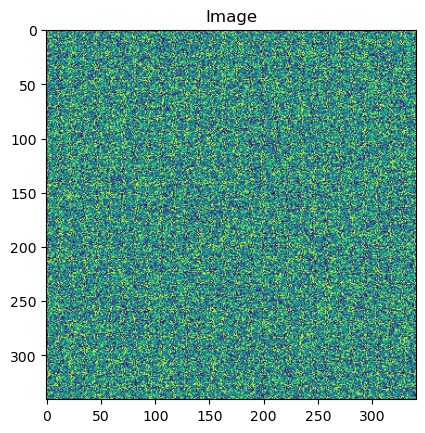

(341, 341, 341, 341)


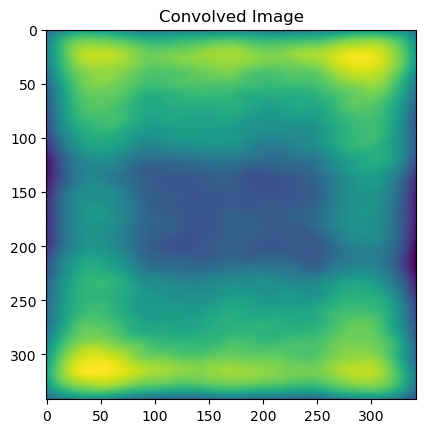

In [16]:
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, pad

# Load the tensor from the saved file
tensor = torch.load('../psfs/psf_1.pt')
# Ensure the tensor is of type float
tensor = tensor.float()

# Create a random image of half the size of the PSF
image = torch.rand(1, 1, tensor.shape[0] // 2, tensor.shape[1] // 2).float()
# make the same image using numpy
print(image.shape)
plt.imshow(image.squeeze().detach().numpy(), cmap='viridis')
plt.title('Image')
plt.show()

# Calculate the required padding to match the PSF size
padding = (tensor.shape[1] // 2, tensor.shape[1] // 2, tensor.shape[0] // 2, tensor.shape[0] // 2)
print(padding)
# Pad the image to match the size of the PSF
padded_image = pad(image, padding)

# Reshape the PSF tensor to match the input dimensions for conv2d
psf_tensor = tensor.unsqueeze(0).unsqueeze(0)

# Perform the convolution
convolved_image = conv2d(padded_image, psf_tensor)

# Plot the convolved image
plt.imshow(convolved_image.squeeze().detach().numpy(), cmap='viridis')
plt.title('Convolved Image')
plt.show()


# Computational Challenges in Convolving Big Matrices for Interferometric Images

When simulating interferometric images, one of the major challenges is handling the convolution of a sky model with a non-local point spread function (PSF). Since the PSF has significant contributions over large distances, the convolution becomes a full matrix operation with a very large, often dense, mask.

## Computational Challenges

- **Memory and Storage:**  
  The convolution process involves a large kernel that extends over most or all of the image. In a direct implementation, each output pixel is computed as a sum over many pixels weighted by the PSF. This quickly becomes memory-intensive, particularly for high-resolution images.

- **Computational Complexity:**  
  Direct convolution scales with the number of image pixels multiplied by the number of PSF pixels. For non-local PSFs—where the kernel size can be comparable to the image size—this leads to a massive number of operations, making the process computationally expensive.

- **GPU Memory Limitations:**  
  Even though frameworks like PyTorch allow leveraging GPUs for accelerated computation, the memory available on GPUs can be a limiting factor when dealing with such large matrices.

## Common Approaches

- **FFT-Based Convolution:**  
  By taking advantage of the convolution theorem, both the image and the PSF can be transformed into Fourier space. This turns the convolution into a point-wise multiplication followed by an inverse FFT, reducing the computational complexity to roughly *O(N log N)*. However, this method requires careful handling of boundary conditions and zero-padding. FFT-based approaches are particularly useful when the PSF is shift-invariant, even if it is non-local.

- **Low-Rank or Separable Approximations:**  
  If the PSF can be approximated as a sum of separable functions or has a low-rank structure, the convolution can be decomposed into a series of smaller, more manageable operations. This reduces both the computational load and memory requirements, though finding a suitable approximation may require some upfront analysis.

- **Iterative and Block Methods:**  
  Instead of computing the full convolution in one go, iterative methods (such as conjugate gradient solvers) can be used when the convolution appears as a linear operator in an inverse problem. Block convolution methods partition the large matrix into smaller blocks that can be processed sequentially or in parallel, which eases memory constraints.

- **Exploiting Sparsity:**  
  In some cases, even though the PSF is non-local, it may exhibit effective sparsity after thresholding small values. Sparse matrix representations and algorithms can help reduce both storage and computation if most of the kernel values are negligible.

- **GPU Acceleration and Optimized Libraries:**  
  Leveraging GPU acceleration (as in PyTorch) and using optimized libraries designed for large-scale convolution can significantly improve performance. These libraries often provide routines specifically optimized for convolution operations in astronomical imaging contexts.

## Summary

The key computational challenge in simulating interferometric images with non-local PSFs is the large-scale convolution operation, which is both memory-intensive and computationally heavy. Researchers typically address this by:

- Transforming the problem into Fourier space using FFTs,
- Employing low-rank or separable approximations,
- Utilizing iterative methods and block-wise processing,
- Exploiting sparsity in the PSF, and
- Leveraging GPU acceleration with optimized libraries.

These strategies aim to reduce the computational complexity and memory footprint, making it feasible to simulate large, high-resolution images even when dealing with complex PSF structures. This multifaceted approach is common in fields like radio astronomy and interferometry, where handling large datasets and non-local effects is a standard part of image synthesis and reconstruction.


### Lets implement the algo that convolve in fourier space
To speed up the process, we use a more straight forward approach. The FFT of the psf is the mask of the active pixels.
- In a more sofisticated approach, we should use a weight mask instead of a binary mask, like "natural" or smth.

The approach is the following:
- Using the previous method to choose the cell size in the image plane, (placing a selected number of pixels along the shortest dimension of the main lobe of the psf) we select the gridding of the image plane.
- This leads to a gridding of the fourier uv space.
- In the fourier space, we activate only the pixels containing a visibility measure.
- We FFT it to get the noisy image.

This approach does not use the same gridder. In general, my opinion is that we should move to use the full simulation
in order to recreate a good noisy image.

# Approach using the simulation tools of casa



Generate one image. The image cell size in arcseconds depends on the size of the main lobe.

It is possible that using a higher resolution image is also fine. Try finding a good
compromise. 

The image must be given as a fits file. Which "decorations" do I have to give to the fits file?
Like which header

A good guide can be found here https://casadocs.readthedocs.io/en/stable/api/tt/casatasks.simulation.simobserve.html#casatasks.simulation.simobserve

### Making the fits file

The FITS file must contain a realistic set of spatial axes, and a realistic flux density. There are several ways to generate a model image.

- Starting from an existing FITS image
- Starting from a component list
- Starting from a GIF or JPG image

Lets try the last one

A user may wish to convert a GIF or JPG image to a FITS file for simulation in CASA. The image should be converted to a 32-bit FITS image for use with the CASA sim tools. See this page for an example of using gimp to convert a JPG image to a FITS file

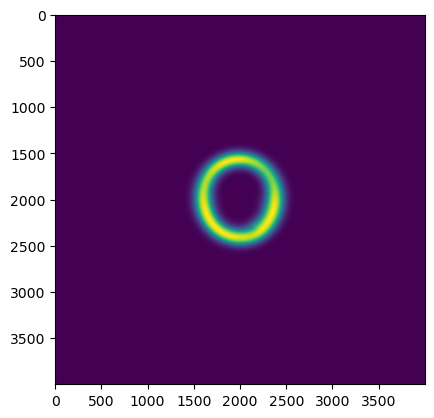

In [17]:
from catalog_manager import CatalogManager
from lensing_system import LensingSystem
from shared_utils import recursive_to_tensor, _grid_lens
from matplotlib import pyplot as plt
import json
import torch

device="cpu"

grid = _grid_lens(8, 4000, device=device)

my_catalog = CatalogManager(catalog_name_input="first_bad_testing_catalog.json")
one_image_dict=my_catalog.catalog["SL_systems"][0]
one_image_dict_tensor=recursive_to_tensor(one_image_dict, device=device)
#print(json.dumps(one_image_dict, indent=4))
lensing_system=LensingSystem(one_image_dict_tensor, device=device)
image=lensing_system(grid)
#add a small sky to the image
#image+=0.1*torch.randn_like(image)
plt.imshow(image.cpu().detach().numpy())
plt.imsave('lensed_image.png', image.cpu().detach().numpy(), cmap='viridis')
plt.show()


In [18]:
! convert lensed_image.png lensed_image.fits

In [19]:
# Import the required CASA tasks and tools
from casatasks import importfits, immath, exportfits
from casatools import image
import os

os.system('rm -rf testimage*')
os.system('rm -rf Einstein.fits')

# Step 1: Import the FITS image into CASA format
importfits(fitsimage='lensed_image.fits', imagename='testimage', overwrite=True)
# os.system('ds9 lensed_image.fits &')
# '''The following modifications (adding coordinates can be done in the simobserve probably, or use imhead to add them here)'''
# # Step 2: Use immath to extract the 0th plane within the specified box region
# immath(imagename='testimage',
#        expr='IM0',
#        box='150, 110, 450, 440',
#        outfile='testimage2')

# # Step 3: Export the resulting CASA image to a new FITS file
# exportfits(imagename='testimage2', fitsimage='masked_lensed_image.fits', overwrite=True)



2025-03-25 09:25:57	WARN	importfits::::casa	This image has no beam or angular resolution provided, so you will not receive warnings from
2025-03-25 09:25:57	WARN	importfits::::casa+	tasks such as imregrid if your image pixels do not sample the the angular resolution well.
2025-03-25 09:25:57	WARN	importfits::::casa+	(This only affects warnings, not any functionality).
2025-03-25 09:25:57	WARN	importfits::::casa+	Providing a beam and brightness units in an image can also be useful for flux calculations.
2025-03-25 09:25:57	WARN	importfits::::casa+	If you wish to add a beam or brightness units to your image, please use
2025-03-25 09:25:57	WARN	importfits::::casa+	the "beam" parameter or ia.setrestoringbeam() and ia.setbrightnessunit()


### Simobserve

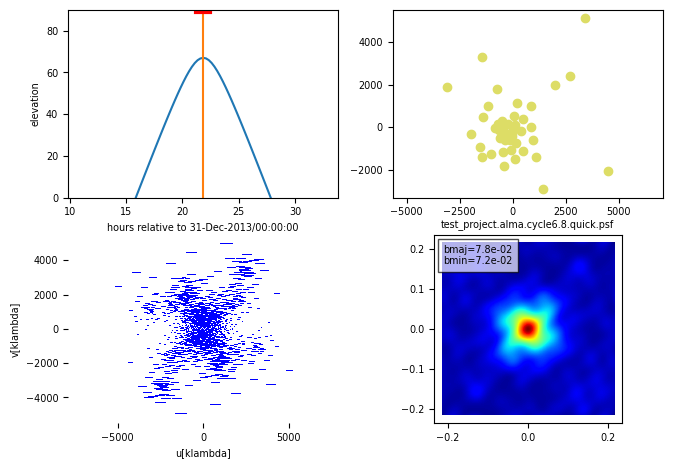

In [9]:
from casatasks import simobserve
import os
#parameters

#inbright: scaling the model flux densities by setting the peack flux density of the brightest pixel
#indirection: set the center target coordinates eg "J2000 19h59m28.5s 40d44m01.5s"
#incell: set the cell size eg "0.01arcsec"
#incenter: set the center frequency eg "100.0GHz"
#inwidth: set the bandwidth eg "0.01GHz"

# os.system('rm -rf test_project*')
# simobserve(project="test_project",
#            skymodel="lensed_image.fits",
#            indirection="J2000 19h59m28.5s 40d44m01.5s",
#            incell="0.01arcsec",
#            incenter="100GHz",  # Add center frequency
#            inwidth="7.5MHz",
#            comp_nchan=128,
#            integration="6.05s",
#            hourangle="1.5h",
#            totaltime="4526s",
#            antennalist="alma.cycle3.8.cfg",
#            sdantlist="aca.tp.cfg",
#            thermalnoise="")  # Specify noise model tsys-atm

#Then we can: set pointings (not needed, small field, no mosaic), set integration time, set noise.

#copying a little bit the set up of https://iopscience.iop.org/article/10.3847/2041-8213/aa7d4a/pdf
os.system('rm -rf test_project*')
simobserve(project="test_project",
           skymodel="lensed_image.fits",
           setpointings=True,
           indirection="J2000 0h00m39.5s 0d0m59.0s",
           incell="0.002arcsec",
           incenter="200.5GHz",
           inwidth="0.1GHz",
           integration="100s",

           obsmode =  "int",

           mapsize=["8.0arcsec","8.0arcsec"],
           hourangle="0h",
           totaltime="4526s",
           antennalist="alma.cycle6.8.cfg",
           #sdantlist="aca.tp.cfg",
           thermalnoise="")


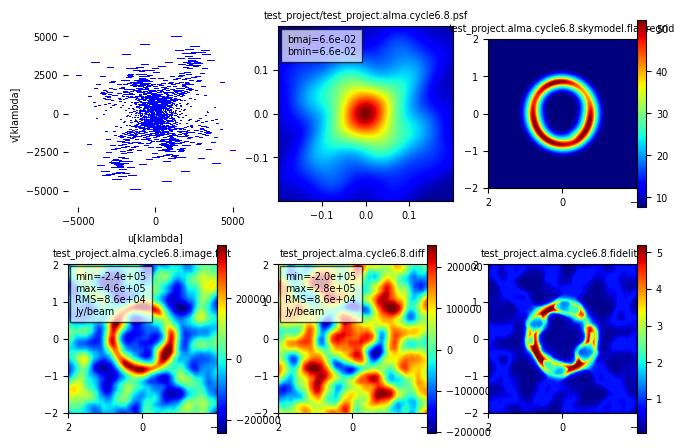

In [10]:
from casatasks import simanalyze

simanalyze(
        project="test_project",
        imsize=4000,
        cell="0.001arcsec",
        imdirection="J2000 0h00m39.5s 0d0m59.0s",
        niter=0,
        analyze=True,
        
)

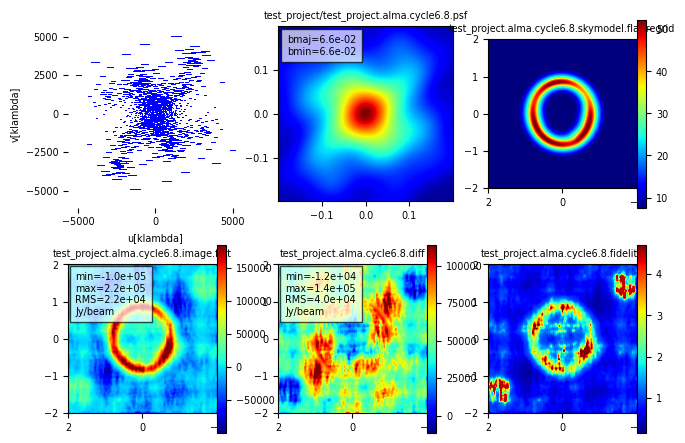

In [20]:
simanalyze(
        project="test_project",
        imsize=4000,
        cell="0.001arcsec",
        imdirection="J2000 0h00m39.5s 0d0m59.0s",
        niter=20000,
        analyze=True,
        overwrite=True
        
)

# Making the psf according to this last alma observation proposal


| **Main Proposal (1 hour per lens)**                                                                 | **High-Res (5-6 hours per lens)**                                                                 |
|-----------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Total Time Requested:** 11.8 hours                                                               | **Total Time Requested:** 5-6 hours per lens                                                     |
| **Number of Lenses:** 12 additional gravitationally lensed starbursts                              | **Number of Lenses:** 6 extremely bright gravitationally lensed starbursts                       |
| **Frequency:** ∼ 350 GHz                                                                           | **Frequency:** 350 GHz (Band 7)                                                                  |
| **Array Configuration:** C-8 array (8 km maximum baseline)                                         | **Array Configuration:** C-10 array (12 to 18 mas beam size)                                     |
| **Angular Resolution:** 30 mas                                                                     | **Angular Resolution:** 12 to 18 mas                                                             |


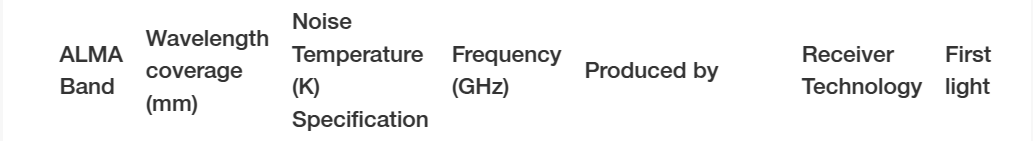
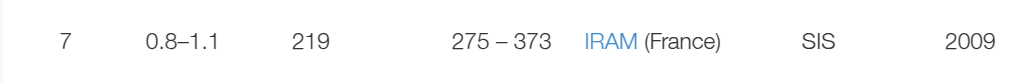

Save the fits file with casa in the correct folder. Torch will load the fits file.
Right now, choose a declination. Later, we will make varying parameter psfs.

Got it. I’ll look into typical ALMA Band 7 continuum setups used for observations of gravitationally lensed starbursts, focusing on matching parameters like bandwidth, number of channels, and spectral configuration. I’ll use this to help you finalize your `makeMSFrame` function based on the proposal's stated configuration.

I’ll let you know shortly what default or representative settings to use.

# Typical ALMA Band 7 Continuum Setup for Lensed Starburst Galaxies

## High Frequency & Extended Array Configuration 
For galaxy–galaxy strong lensing studies of dusty starbursts, observers often use ALMA **Band 7 (~0.87 mm, ~350 GHz)** in one of its most extended configurations. This is necessary to achieve the **very high angular resolution** (on the order of **tens of milliarcseconds**) needed to resolve lensed structures. For example, the ALMA long-baseline science verification on the lensed galaxy **SDP.81** (at *z*≈3.0) demonstrated ~25 mas resolution at 1 mm using baselines up to 15 km ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=ALMA%20can%20have%20very%20high,13%20show%20a%20tapered)) ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=and%20the%20amplification%20factor%20is,5)). A configuration like **C-8** (with maximum baselines ~8 km) is well suited for ~30 mas resolution at 350 GHz, given good observing conditions. Such long baselines require excellent atmospheric stability (PWV ~0.5 mm or better) since Band 7 is a high-frequency band.

- **Array config & resolution:** ALMA’s extended 12 m array (e.g. C-8 or longer) is used to reach **≲0.03″ (30 mas)** resolution in Band 7 ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=and%20the%20amplification%20factor%20is,5)). This leverages baselines of several kilometers (up to ~8–10 km for ~30 mas), similar to past high-res studies (e.g., SDP.81 used baselines up to 15 km for a 25 mas beam ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=and%20the%20amplification%20factor%20is,5))).  
- **Number of lensed targets:** Studies often observe multiple lensed starbursts; for instance, samples of ~10–12 lensed DSFGs (dusty star-forming galaxies) have been targeted in survey programs (e.g. the **Planck’s Dusty GEMS** of 11 bright lensed galaxies ([Planck’s dusty GEMS - IV. Star formation and feedback in a maximum starburst at z = 3 seen at 60-pc resolution | Astronomy & Astrophysics (A&A)](https://www.aanda.org/articles/aa/abs/2017/08/aa30186-16/aa30186-16.html#:~:text=We%20present%20an%20analysis%20of,Local))). Each target is typically observed in a separate execution block.  

## Spectral Windows and Bandwidth for Continuum 
To maximize continuum sensitivity, ALMA observations use the **full available bandwidth** spread over multiple spectral windows. A **continuum-only setup** in Band 7 generally takes advantage of all four basebands:

- **Number of spectral windows:** **4 SPWs** (the maximum in one tuning) are used for continuum ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)). This allows capturing a broad frequency range for optimal sensitivity and *uv*-coverage.  
- **Bandwidth per SPW:** Each spectral window covers about **1.875–2.0 GHz** of bandwidth ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)). In ALMA’s correlator, each 2 GHz baseband is typically recorded in **Time Division Mode (TDM)** for continuum, giving the full wide bandwidth. (Older documents often quote a total of 7.5 GHz across 4 SPWs due to a small gap or edge channels, but roughly ~8 GHz total is achieved ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)).)  
- **Channels per SPW & width:** Continuum-mode SPWs are configured with **128 channels** of **~15.625 MHz** each ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)). This coarse resolution is used since line details aren’t needed for pure continuum. For example, a published Band 7 continuum observation had each SPW 2.0 GHz wide with 15.625 MHz channels (128 channels × 15.625 MHz = 2 GHz) ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)). This channel width is far larger than any line width, effectively averaging to measure the continuum flux. (If a spectral line is of interest in the same setup, typically one SPW might be configured at higher resolution ~1 MHz channels for that line ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=Band%204%2C%20a%200,7%20line%20%28vrest)), while the remaining SPWs stay wide for continuum.)  
- **Total bandwidth:** With 4 wide SPWs, the **aggregate bandwidth** is ~**7.5–8 GHz** in dual polarization, which is standard for ALMA continuum observations ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)). This large bandwidth is crucial for high sensitivity to dust emission. For instance, the ALMA long-baseline imaging of SDP.81 divided ~7.5 GHz into four windows (three for continuum, one for a line) ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)), illustrating the use of the full bandwidth.  

## Tuning (Central Frequency) for Band 7 Continuum 
The SPWs in Band 7 are typically placed to cover a broad frequency range around the band’s center while avoiding major atmospheric absorption features. In practice, observers often split the 4 SPWs between the two sidebands of a single LO tuning. A representative continuum tuning might center two SPWs in the lower sideband and two in the upper sideband. 

- **Representative frequency setup:** A common choice is to center the LO around ~343–345 GHz, yielding two SPWs near ~337–339 GHz and two near ~349–351 GHz ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=5%20196,Frequencies%20were%20chosen)). For example, ALMA’s default continuum polarization tuning in Band 7 uses SPW center frequencies **336.5, 338.5, 348.5, and 350.5 GHz** (with an LO at 343.5 GHz) ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=5%20196,Frequencies%20were%20chosen)). Each of those SPWs is ~1.875 GHz wide, so together they span approximately 334–353 GHz. This kind of setup samples a broad portion of Band 7 and avoids regions of higher atmospheric opacity, thus “optimizing spectral performance” in low-noise parts of the band ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=Table%20A,258%20MHz%20in%20each%20Band)).  
- **Choice of central frequency:** For a generic continuum observation of a 350 GHz target, one can aim to **center the tuning around ~350 GHz**. In practice, the exact placement can be adjusted if a particular redshifted line or atmospheric feature needs to be avoided. Since our case is continuum-only at ~350 GHz, using a symmetric setup around 343–350 GHz (as above) would be appropriate. This ensures none of the 4 SPWs sits exactly at a strong atmospheric line (maximizing throughput).  

## Integration Time and Sensitivity 
Each lensed starburst is typically bright in the submillimeter (tens to hundreds of mJy), so **on-source integration ~1 hour per target** is often sufficient to achieve a good SNR in continuum at 0.03″ resolution. In the literature, integration times per source have varied depending on the science goals:

- **Per-source observing time:** ~**1 hour on-source** is a reasonable allocation for continuum mapping of a bright lensed DSFG. For instance, some survey programs targeting multiple lensed galaxies dedicate on the order of an hour or a few hours each to reach the desired depth. (By contrast, the SDP.81 long-baseline campaign spent a total of ~30 hours on that single target across three bands ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=galaxy%2C%20with%20an%20SFR%20%3D,with%20only%2022%20to%2036)) – but that included high spectral resolution for multiple lines and was a special demonstration.) In normal proposals, 1 hour per source in Band 7 continuum can deliver high-fidelity imaging for sources ~0.1–0.5 Jy, especially with lensing magnification aiding the sensitivity.  
- **Sensitivity considerations:** With ~8 GHz bandwidth and 1 hr integration, ALMA can reach RMS noise of a few tens of μJy (depending on conditions and number of antennas). This is well-matched to detecting the dust continuum of luminous lensed starbursts. Published continuum imaging of lensed galaxies (e.g. the **H-ATLAS and Planck-selected lenses**) have achieved detections and resolved structure with similar or less integration time thanks to their brightness.  

## Polarization and Stokes Setup 
For standard continuum observations, **dual polarization** is used by default. ALMA’s receivers record two orthogonal polarizations (X and Y), which are combined to produce Stokes **I** (total intensity) maps. No special polarization setup is required unless the science goal is to measure polarized emission. In our context (continuum imaging of dust emission), only Stokes I is of interest, so the default dual-pol continuum mode is ideal:

- **Polarization mode:** **Dual polarization (two linear feeds)** is employed in all continuum observations, providing sensitivity in both polarizations. The data are typically processed as total intensity. (Full polarization measurements with all Stokes require a dedicated setup and calibration; those are not needed for a continuum-only imaging project.) The **standard continuum correlator mode** in dual-pol maximizes sensitivity by effectively doubling the observed bandwidth (two polarizations across the same 4 SPWs). The ALMA Observing Tool automatically sets this up for continuum projects.  
- **Stokes products:** The resulting Measurement Set will contain XX and YY correlation products (or equivalently two cross-hands for circulars), but unless one performs a polarimetric calibration, one usually just combines them to make a Stokes I image. In summary, you can assume **Stokes I** as the output image. No separate Stokes setup is needed – just use the default continuum (which records both pols and thus captures I). 

## Summary of Recommended Setup Parameters 
Based on common ALMA Band 7 continuum setups in the literature, the following configuration can be used to simulate the observations of 12 lensed starbursts at 350 GHz with 30 mas resolution (C-8 configuration), 1 hour each:

- **Band/Frequency:** ALMA **Band 7** (around **343–350 GHz** continuum). For example, center the LO ~345 GHz and use SPWs covering ≈337 GHz and 349 GHz (two in each sideband) ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=5%20196,Frequencies%20were%20chosen)).  
- **Spectral windows:** **4 SPWs** in continuum mode (all wideband). This is the maximum to capture ~8 GHz total bandwidth ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)).  
- **Bandwidth per SPW:** **≈1.875 GHz** effective bandwidth each (the full baseband). Each SPW uses the widest channel setup (TDM) yielding ~2 GHz per window ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)).  
- **Channels and resolution:** **128 channels/SPW**, each of **15.625 MHz** width (for continuum, no high spectral resolution needed) ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)). This corresponds to a very coarse velocity resolution (~**1.9 km/s** at 350 GHz ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=5%20196,Frequencies%20were%20chosen)), which is fine for continuum). The channel count and width can be set in the simulator accordingly (e.g. in CASA’s `simobserve`, specify 128 channels of width 15.625 MHz for each SPW).  
- **Total bandwidth:** ~**7.5 GHz** usable continuum bandwidth (4 × 1.875 GHz in dual polarization) ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)). This maximizes continuum sensitivity to dust emission.  
- **Central frequency:** **~350 GHz** for continuum. In practice, split into two pairs of SPWs around ~338 GHz and ~350 GHz to cover a broad range and avoid atmospheric lines ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=5%20196,Frequencies%20were%20chosen)). If using a single representative frequency, ~345 GHz (0.87 mm) is a good central choice.  
- **Polarization setup:** **Dual-pol (standard)**. The MS should have two polarization products (X & Y or equivalently dual linear feeds) but will be imaged for **Stokes I** continuum. No full-Stokes special setup is required for total intensity mapping.  
- **Integration time:** **3600 s on-source per target** (plus calibration overheads). This 1 hr integration per lens is typical for achieving high SNR on bright lensed starbursts. In simulation, one can set 1 hr total time and include appropriate calibration intervals if needed.  
- **Angular resolution:** ~**0.03″ beam** expected. Ensure the array configuration reflects baselines up to ~8 km (e.g. choose an ALMA configuration file for C-8 or similar in CASA). Past studies achieved 25–30 mas at Band 7 with such configurations ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=and%20the%20amplification%20factor%20is,5)).  

Using these parameters will closely mimic the setups used in real ALMA observations of strongly lensed dusty starbursts in Band 7 continuum. For instance, the **ALMA SV imaging of SDP.81** utilized a very similar configuration (four ~2 GHz SPWs, 15 MHz channels) to attain sub-0.05″ resolution ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)) ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)). Adopting this setup in a measurement set simulation will allow you to accurately reproduce the performance (uv-coverage, resolution, and sensitivity) of those observations, providing a realistic mock dataset for your 12 lensed galaxies.

**Sources:** High-resolution ALMA observations of lensed sub-mm galaxies have employed four 1.875 GHz-wide spectral windows for continuum ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)), with coarse 15.6 MHz channel spacing in each window ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)). This yields ~8 GHz total bandwidth in dual polarization, centered around Band 7 frequencies ([](https://almascience.nrao.edu/documents-and-tools/cycle11/alma-proposers-guide#:~:text=5%20196,Frequencies%20were%20chosen)). The ALMA Long Baseline Campaign (2014) achieved ~30 mas resolution at 1 mm on a lensed galaxy using 8–15 km baselines ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=and%20the%20amplification%20factor%20is,5)), and subsequent studies have adopted ~hour-long integrations per target for continuum imaging of bright lensed starbursts. The above configuration is consistent with those used in the literature and ALMA technical guidelines, ensuring a realistic simulation of the proposed observations.  ([](https://thejournalofcosmology.com/ALMA.Gib.1503.02652v3.pdf#:~:text=For%20each%20of%20Bands%204%2C,202%20%E2%88%92)) ([a 200-pc mapping of the interstellar medium in the redshift-3 lensed ...](https://academic.oup.com/mnras/article-pdf/494/4/5542/34135872/staa879.pdf#:~:text=,MNRAS%20494%2C%205542)) ([Molecular gas in distant galaxies from ALMA studies -
F. Combes](https://ned.ipac.caltech.edu/level5/March18/Combes/Combes5.html#:~:text=and%20the%20amplification%20factor%20is,5))

For ALMA continuum simulations the integration time defines the duration of each individual visibility sample. In practice, ALMA observations—especially at high frequencies like Band 7 where high angular resolution is needed—often use short integration times (on the order of 10–30 seconds) to minimize time smearing and to adequately sample the uv-plane.

In your code snippet the integration time is set to '1000s', which would result in very few integrations over a 1‐hour total scan. For a 1‑hour observation, a more typical integration time might be:

- **10s** per integration → about 360 samples in 1 hour  
- **30s** per integration → about 120 samples in 1 hour

I recommend using around **10s** to **30s** for high-resolution Band 7 continuum imaging. This choice ensures that you capture enough time resolution to properly reconstruct the image while avoiding smearing effects.

In [3]:
# Import required tools/tasks
from casatools import simulator, image, table, coordsys, measures, componentlist, quanta, ctsys, vpmanager
from casatasks import tclean, ft, imhead, listobs, exportfits, flagdata, bandpass, applycal
from casatasks.private import simutil

import os
import pylab as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


# Instantiate all the required tools
sm = simulator()
ia = image()
tb = table()
cs = coordsys()
me = measures()
qa = quanta()
cl = componentlist()
vp = vpmanager()
qa = quanta()
mysu = simutil.simutil()

measures_update ... acquiring the lock ... 
  ... connecting to ftp.astron.nl ...
  ... downloading WSRT_Measures_20250412-160001.ztar from ASTRON server to /home/francesco/.casa/data ...
  ... measures data updated at /home/francesco/.casa/data


In [2]:
def makeMSFrame(msname= "sim_data2.ms"):
    """
    Construct an empty measurment set that has the desired observation setup.
    """


    os.system("rm -rf " + msname)
    sm.open(ms=msname);

    # Read/create an antenna configuration  alma.cycle12.10.cfg 
    #antennalist = os.path.join( ctsys.resolve("alma/simmos") ,"vla.d.cfg")   

    # checked on the website and the alma.cycle10.1.cfg corresponds to c-8 with 85000 km baselines and a beamsize of 0.096. (at 100 GHz) which in our fre
    antennalist = os.path.join( ctsys.resolve("alma/simmos") ,"alma.cycle10.8.cfg")   


    # Read xyz locations, antenna diameter and name, and telescope name/positoin.
    (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)
    obsposname=telname


    # Now we use the premade antenna configuration to set the simulator
    sm.setconfig(telescopename=telname,
                 x=x,
                 y=y,
                 z=z,
                 dishdiameter=d,
                 mount='alt-az',
                 antname=an,
                 coordsystem='global',
                 referencelocation=me.observatory(obsposname))
    
    # Set the polarization mode(this goes to the FEED subtable)
    sm.setfeed(mode='perfect R L', pol=[''])
    
    ## Set the spectral window and polarization 
    #Call multiple times with different names for multiple SPWs
    sm.setspwindow(spwname="spw1",
                   freq='336.5GHz',
                   deltafreq='2.0GHz',
                   freqresolution='15.625MHz',
                   nchannels=128,
                   stokes='RR LL')
    sm.setspwindow(spwname="spw2",
                   freq='338.5GHz',
                   deltafreq='2.0GHz',
                   freqresolution='15.625MHz',
                   nchannels=128,
                   stokes='RR LL')
    sm.setspwindow(spwname="spw3",
                   freq='348.5GHz',
                   deltafreq='2.0GHz',
                   freqresolution='15.625MHz',
                   nchannels=128,
                   stokes='RR LL')
    sm.setspwindow(spwname="spw4",
                   freq='350.5GHz',
                   deltafreq='2.0GHz',
                   freqresolution='15.625MHz',
                   nchannels=128,
                   stokes='RR LL')
    
    
    #set source position and name, repeat for multiple sources
    sm.setfield( sourcename="fake",
                sourcedirection=me.direction(rf='J2000', v0='14h10m50.5s', v1='-23d01m01.5s'))
    
    ## Set shadow/elevation limits. These will set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='1deg')

    # Leave autocorrelations out of ms, the correlation of an antenna with itself
    sm.setauto(autocorrwt=0.0)

    # Set integration time and the convention to use for timerange specificaition
    sm.settimes(integrationtime='10s',
                usehourangle=True,
                referencetime=me.epoch('UTC','2019/10/4/00:00:00'))
    #Make the MS metadata and UVW values for one scan and ddid
    ## Call multiple times for multiple scans
    ## call this with different sourcenames(fields) and spw/pol settings as defined above.
    ## Timesteps will be defined in intervals of integration time. betweeen starttime and stoptime
    sm.observe(sourcename="fake",
               spwname="spw1",
               starttime='-0.5h',
               stoptime='+0.5h')
    sm.observe(sourcename="fake",
               spwname="spw2",
               starttime='-0.5h',
               stoptime='+0.5h')
    sm.observe(sourcename="fake",
               spwname="spw3",
               starttime='-0.5h',
               stoptime='+0.5h')
    sm.observe(sourcename="fake",
               spwname="spw4",
               starttime='-0.5h',
               stoptime='+0.5h')
    
    
    
    sm.close()

    #unflag everything, unless you care about elevation and shadow flags
    flagdata(vis=msname, mode='unflag')
    

In [5]:
makeMSFrame()

In [7]:
plotData(msname="sim_data2.ms",myplot='uv')

NameError: name 'plotData' is not defined

(3, 1300320)


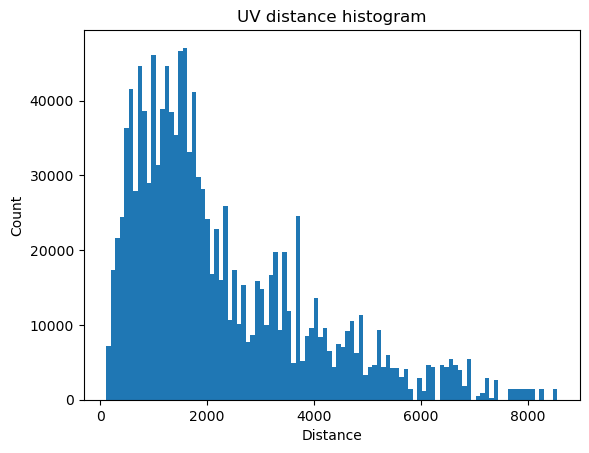

Max radius: 8547.792195502272
This, when compred to the uvwave plot of casa, seems to be not in units of wavelength.
Mean_wavelegnth: 0.0008683068017366136
Max radius in wavelengths: 9844207.34515345
Confirmation from the docs, UVW is in meters.
this seems to match the uvwave plot in casa, which is in units of wavelengths.


In [8]:
tb.open('sim_data2.ms')
uvw = tb.getcol('UVW')
tb.close()
print(uvw.shape)

uvdist= np.sqrt(uvw[0]**2 + uvw[1]**2)
pl.figure()
pl.hist(uvdist, bins=100)
pl.title('UV distance histogram')
pl.xlabel('Distance')
pl.ylabel('Count')
pl.show()

max_uvdist_radius = uvdist.max()
print('Max radius:', max_uvdist_radius)
print('This, when compred to the uvwave plot of casa, seems to be not in units of wavelength.')
#300 gigahertz in meters are 0.001 meters.
mean_wavelength = 3e8/345.5e9
print(f"Mean_wavelegnth: {mean_wavelength}")
print('Max radius in wavelengths:', max_uvdist_radius/mean_wavelength)
print('Confirmation from the docs, UVW is in meters.')
print("this seems to match the uvwave plot in casa, which is in units of wavelengths.")

In [13]:

number_of_cells_across_beam=3
cell_size_arcsec=206265/(max_uvdist_radius/mean_wavelength)/number_of_cells_across_beam
cell_size_arcsec_str = str(cell_size_arcsec)+'arcsec'


In [1]:
image_size_arcesc = 16
number_of_pixels =round(image_size_arcesc/cell_size_arcsec)
#round the number of pixels to the nearest higher multiple of 4
number_of_pixels = (number_of_pixels//4 + 1)*4
print(number_of_pixels)

NameError: name 'cell_size_arcsec' is not defined

In [16]:
os.system('rm -rf fake*')
tclean(vis='sim_data2.ms',
       imagename='fake',
       field='0',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[number_of_pixels, number_of_pixels],
       cell=[cell_size_arcsec_str],
       weighting='natural',
       threshold='0.0mJy',
       interactive=True)

2025-04-13 15:49:10	WARN	SynthesisParamsImage::buildCoordinateSystem (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2565)	imsize with 2292 pixels is not an efficient imagesize. Try 2304 instead.

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2025-04-13 15:50:49	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2298)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 0,
 'cyclethreshold': 0,
 'interactiveiterdone': 0,
 'interactivemode': True,
 'interactiveniter': 0,
 'interactivethreshold': 0,
 'iterdone': 0,
 'loopgain': 0,
 'maxpsffraction': 0,
 'maxpsfsidelobe': 0,
 'minpsffraction': 0,
 'niter': 0,
 'nmajordone': 1,
 'nsigma': 0.0,
 'stopcode': 3,
 'summarymajor': array([0]),
 'summaryminor': {0: {0: {0: {'iterDone': [0.0],
     'peakRes': [0.0],
     'modelFlux': [0],
     'cycleThresh': [0.0]}}}},
 'threshold': '0.0mJy',
 'stopDescription': 'Zero iterations performed'}

In [17]:
exportfits(imagename='fake.psf', fitsimage='../psfs/devon_first_advice_psf_20_pix_16_arcsec.fits', overwrite=True)

In [13]:
#dispImage(imname='fake.psf', useAstropy=False)
os.system('ds9 ../psfs/fake_psf.fits &')

0

### Now lets try convolving this psf with one image
The image should be half the pixel size of the psf. Then, It should be padded.

Psf side pixels: 5348


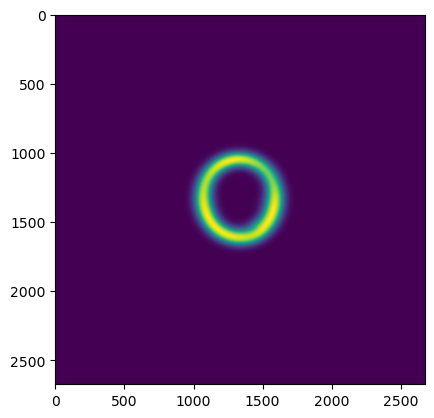

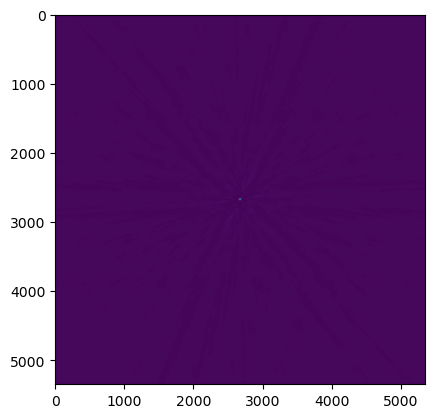

In [15]:
#use casatask to convert the psf obtained into a fits file
from catalog_manager import CatalogManager
from lensing_system import LensingSystem
from shared_utils import recursive_to_tensor, _grid_lens
from matplotlib import pyplot as plt
import json
import torch

device="cpu"
print(f"Psf side pixels: {number_of_pixels}")

grid = _grid_lens(8, round(number_of_pixels/2.), device=device)

my_catalog = CatalogManager(catalog_name_input="first_bad_testing_catalog.json")
one_image_dict=my_catalog.catalog["SL_systems"][0]
one_image_dict_tensor=recursive_to_tensor(one_image_dict, device=device)
#print(json.dumps(one_image_dict, indent=4))
lensing_system=LensingSystem(one_image_dict_tensor, device=device)
image=lensing_system(grid)
#add a small sky to the image
#image+=0.1*torch.randn_like(image)
plt.imshow(image.cpu().detach().numpy())
plt.imsave('lensed_image.png', image.cpu().detach().numpy(), cmap='viridis')
plt.show()

from astropy.io import fits
import torch
import matplotlib.pyplot as plt

# Open the FITS file and load the image data
with fits.open('../psfs/fake_psf.fits') as hdul:
    data = hdul[0].data
    # Convert the data to the native byte order if necessary
    data = data.byteswap().newbyteorder()

# Convert the NumPy array to a torch tensor (as a float tensor)
psf_tensor = torch.from_numpy(data).float()

# Display the image using matplotlib
plt.imshow(psf_tensor.squeeze(0).squeeze(0))
plt.show()

In [16]:
print(psf_tensor.shape)
print(image.shape)


torch.Size([1, 1, 5348, 5348])
torch.Size([2674, 2674])


In [17]:
image=image.unsqueeze(0).unsqueeze(0)
print(image.shape)

torch.Size([1, 1, 2674, 2674])


Padded image shape: torch.Size([1, 1, 5348, 5348])


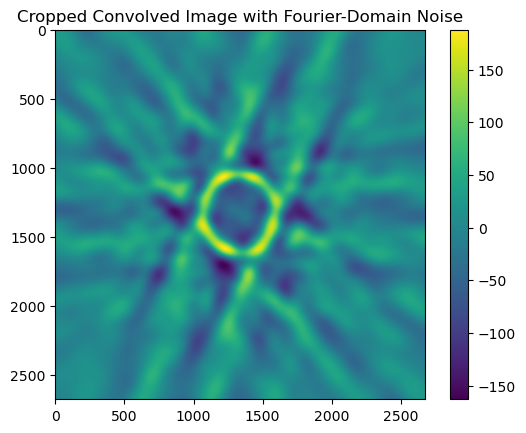

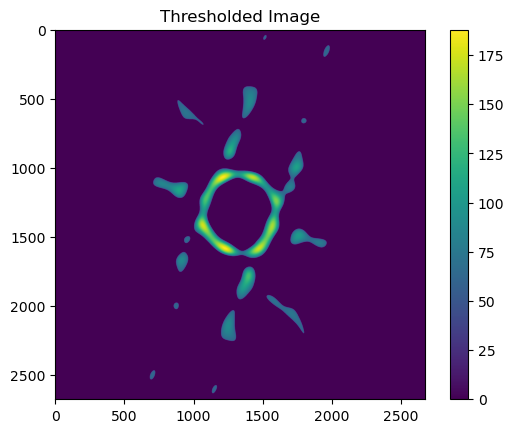

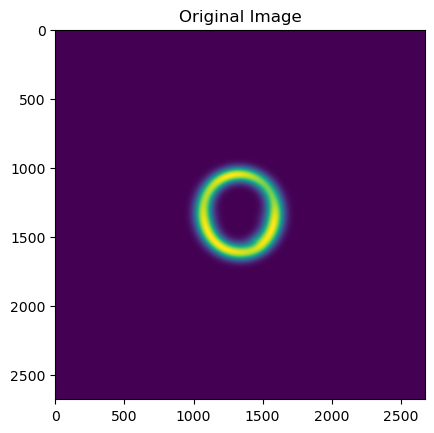

In [18]:
import torch
import torch.nn.functional as F
import torch.fft
import matplotlib.pyplot as plt

# Suppose 'image' is the original image tensor of shape [1, 1, H, W]
H, W = image.shape[2], image.shape[3] # original image dimensions

# Pad the image equally on all sides: (left, right, top, bottom)
padding = (W//2, W//2, H//2, H//2)
padded_image = F.pad(image, padding, mode='constant', value=0)
print(f"Padded image shape: {padded_image.shape}")  # Expected shape: [1, 1, 2H, 2W]


# Shift the PSF so that its center is at (0,0) in Fourier domain
psf_shifted = torch.fft.ifftshift(psf_tensor, dim=(-2, -1))

# Compute the FFTs along the spatial dimensions (-2, -1)
image_fft = torch.fft.fftn(padded_image, dim=(-2, -1))
psf_fft   = torch.fft.fftn(psf_shifted, dim=(-2, -1))

# Perform the convolution in the Fourier domain using the convolution theorem
conv_fft = image_fft * psf_fft

# Add uncorrelated noise in the Fourier domain.
# We generate complex noise with independent real and imaginary parts.
noise_std = 0  # standard deviation for the noise (adjust as needed)
noise_real = torch.randn_like(conv_fft.real) * noise_std
noise_imag = torch.randn_like(conv_fft.imag) * noise_std
noise_fourier = torch.complex(noise_real, noise_imag)

# Add the Fourier-domain noise to the convolution result
conv_fft_noisy = conv_fft + noise_fourier

# Apply the inverse FFT to get back to the spatial domain.
# Take the real part as the final convolved image.
convolved_image_noisy = torch.fft.ifftn(conv_fft_noisy, dim=(-2, -1)).real

# Crop the convolved image to the original image size.
# Since the padded image has shape [1, 1, 2H, 2W],
# we extract the central region corresponding to [H, W].
start_h = H // 2
start_w = W // 2
cropped_image = convolved_image_noisy[:, :, start_h:start_h+H, start_w:start_w+W]

# Display the final noisy convolved image
plt.imshow(cropped_image.squeeze(), cmap='viridis')
plt.title("Cropped Convolved Image with Fourier-Domain Noise")
plt.colorbar()
plt.show()

thresholded_image=cropped_image.where(cropped_image>60, 0)
plt.imshow(thresholded_image.squeeze(), cmap='viridis')
plt.title("Thresholded Image")
plt.colorbar()
plt.show()

plt.imshow(image.squeeze(), cmap='viridis')
plt.title("Original Image")
plt.show()

In [128]:
# save the noisy convolved image as a fits file 
hdu = fits.PrimaryHDU(cropped_image.squeeze().detach().numpy())
hdu.writeto('noisy_convolved_image.fits', overwrite=True)


In [18]:
#clean the folder
os.system('rm -rf test_project*')
os.system('rm casa*.log')
os.system('rm -rf fake*')
os.system('rm -rf sim_data*')
os.system('rm -rf testimage*')
os.system('rm -rf Einstein.fits')
os.system('rm -rf lensed_image.png')
os.system('rm -rf lensed_image.fits')
os.system('rm -rf TempLattice*')
os.system('rm -rf dirty*')
os.system('rm masked_lensed_image.fits')
os.system('rm noisy_convolved_image.fits')
os.system('rm  plotms.last')
os.system('rm -rf obslist.txt')
os.system('rm tclean.last')


rm: cannot remove 'masked_lensed_image.fits': No such file or directory
rm: cannot remove 'noisy_convolved_image.fits': No such file or directory
rm: cannot remove 'plotms.last': No such file or directory
rm: cannot remove 'tclean.last': No such file or directory


256

In [31]:
import numpy as np

grades=np.array([1.3, 2.0, 2.3, 1.7, 1.3, 1.7, 1.7, 3, 1.0, 1.0])
weights=np.array([6,    6,   9,   9,   9,   9,   9,  6, 30, 3])

print("total weights:", np.sum(weights))
print(np.average(grades, weights=weights))

total weights: 96
1.5531249999999999
